# Redfield Tensor and Bath Diagnostics

This notebook demonstrates the setup and analysis of a two-atom open quantum system using Bloch-Redfield theory. It includes:
- System initialization and parameter setup
- Calculation and comparison of Redfield tensors
- Physical checks such as the KMS (detailed balance) condition
- Visualization of bath power spectra and transition frequencies

All code and plots are formatted for clarity and reproducibility.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from qutip import *

from qspectro2d.utils import BOLTZMANN, HBAR
from qspectro2d.config import create_base_sim_oqs
from qspectro2d.core.bath_system import extract_bath_parameters
from qspectro2d.core.atom_bath_class import AtomBathCoupling
from qspectro2d.core.bath_system.bath_fcts import power_spectrum_func_paper, power_spectrum_func_ohmic, extract_bath_parameters

custom_dir = Path("test_Redfield_tensor")
custom_dir.mkdir(exist_ok=True)

from plotstyle import init_style, COLORS, LINE_STYLES
init_style()

## System configuration helper

We wrap the system setup into a helper function so that parameter changes (such as the number of atoms) always rebuild the basis, prepare the ground state, and refresh the coupling matrix without manual calls to private methods.

In [2]:
def configure_two_level_system(
    system: "AtomicSystem",
    frequencies_cm: list[float],
    dip_moments: list[float],
    max_excitation: int = 2,
) -> None:
    """Configure an `AtomicSystem` with consistent basis and coupling data."""
    if len(frequencies_cm) != len(dip_moments):
        raise ValueError("Frequencies and dipole lists must have identical length.")

    n_atoms = len(frequencies_cm)
    system.n_atoms = n_atoms
    system.max_excitation = max_excitation
    system.dip_moments = list(dip_moments)

    system._build_basis()
    system.psi_ini = ket2dm(system.basis[system.idx_ground()])

    system.update_frequencies_cm(list(frequencies_cm))
    system._setup_geometry_and_couplings()
    system.reset_cache()

In [3]:
# TODO PATH TO THIS FILE
config_path = SIM_CONFIGS_DIR / "template.yaml"
sim_oqs, time_cut = create_base_sim_oqs(config_path=str(config_path))

sim_oqs.simulation_config.ode_solver = "BR"
configure_two_level_system(
    system=sim_oqs.system,
    frequencies_cm=[16200.0, 15800.0],
    dip_moments=[1.0, 1.0],
    max_excitation=2,
)

print(
    "Configured system: n_atoms=%d, dim=%d" % (sim_oqs.system.n_atoms, sim_oqs.system.dimension)
)

NameError: name 'SIM_CONFIGS_DIR' is not defined

In [ ]:
times = sim_oqs.times_global

H = sim_oqs.evo_obj # QobjEvo
t0 = times[0]
t_peak = sim_oqs.laser.pulse_peak_times[0]

# TODO build the redfield tensor for both time points to check weather or not it is time dependent
H_0 = H(t0)
H_peak = H(t_peak)
R_t0 = bloch_redfield_tensor(H_0, sim_oqs.decay_channels)
R_tpeak = bloch_redfield_tensor(H_peak, sim_oqs.decay_channels)

c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\qutip\utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


## Redfield Tensor Calculation

This section calculates the Bloch-Redfield tensor at different time points to check for time dependence in the dissipative dynamics.

In [ ]:
print(R_t0[1], R_tpeak[1])

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-6.97678576e-03  0.00000000e+00  9.99951323e-01  6.97678576e-03]
 [-9.99951322e-01 -6.97712539e-03 -6.97644612e-03 -4.86779091e-05]
 [-4.86779091e-05  6.97712539e-03  6.97644612e-03 -9.99951322e-01]
 [-6.97678576e-03  9.99951319e-01 -9.73558181e-05  6.97678576e-03]] Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.22774426  0.          0.94671279  0.22774426]
 [ 0.94512083 -0.2405632  -0.21415938 -0.05487917]
 [ 0.05487917  0.2405632   0.21415938 -0.94512083]
 [ 0.22774426  0.9403503  -0.10957377  0.22774426]]


(<Figure size 800x600 with 2 Axes>, <Axes3D: >)

c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


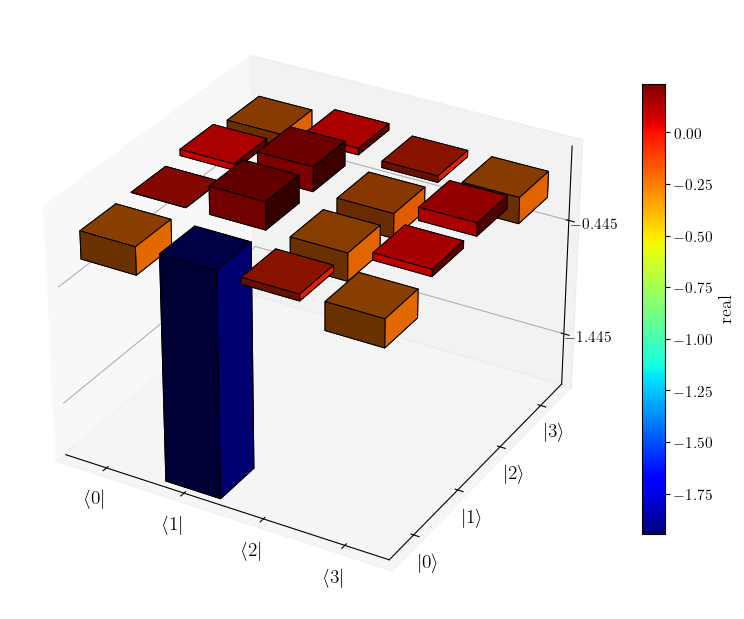

In [ ]:
# xbasis 0<-0, 0<-1, 0<-2, 0<-3, 1<-0, 1<-1, 1<-2, 1<-3, 2<-0, 2<-1, 2<-2, 2<-3, 3<-0, 3<-1, 3<-2, 3<-3
dims = sim_oqs.system.dimension
xbasis = [f"{i},{j}" for i in range(dims) for j in range(dims)]
ybasis = xbasis.copy()
#matrix_histogram(R_t0[0] - R_tpeak[0], bar_style="phase", x_basis=xbasis, y_basis=ybasis)
matrix_histogram(R_t0[1] - R_tpeak[1], bar_style="real")

In [ ]:
print(isinstance(sim_oqs.bath, BosonicEnvironment))
w0 = sim_oqs.system.frequencies_fs[0]
print(extract_bath_parameters(sim_oqs.bath, w0=w0))

True
{'T': 1e-06, 'temp': 1e-06, 'tag': 'ohmic', 'S(0)': 2e-09, 'S(w0)': 0.00591975332425408, 'alpha': 0.001, 'wc': 100.0, 'cutoff': 100.0, 's': 1.0}


c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\qutip\utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


C:\Users\leopo\AppData\Local\Temp\ipykernel_23272\1967889655.py:61: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
C:\Users\leopo\AppData\Local\Temp\ipykernel_23272\1967889655.py:74: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
C:\Users\leopo\AppData\Local\Temp\ipykernel_23272\1967889655.py:79: RuntimeWarning: overflow encountered in exp
  n_thermal = 1 / (np.exp(HBAR * w_positive / kT) - 1)


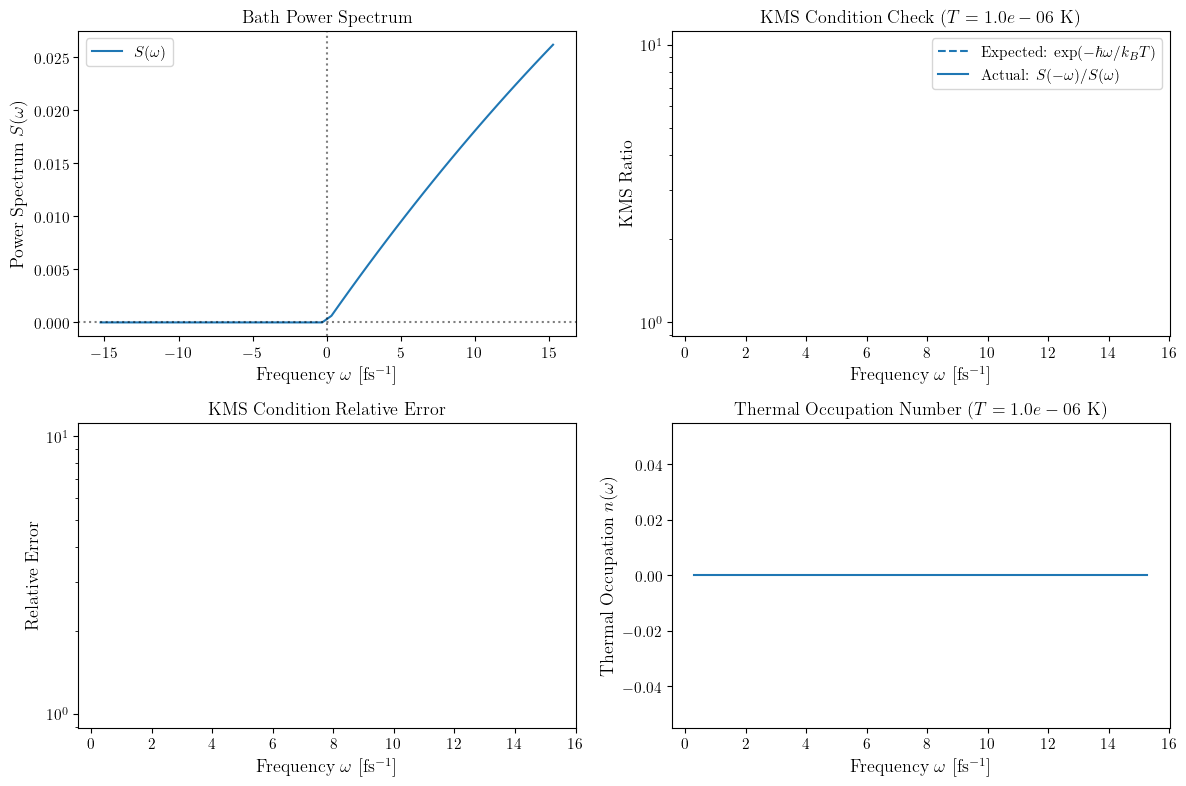


DETAILED BALANCE / KMS CONDITION CHECK
Bath temperature: 1.00e-06 K
Thermal energy kT: 1.00e-06 eV
Maximum relative error: 0.00e+00
Mean relative error: 0.00e+00
✅ KMS condition is satisfied (error < 1e-6)


In [ ]:
bath = sim_oqs.bath
w = np.linspace(-5 * w0, 5 * w0, 50)
# DETAILED BALANCE / KMS CONDITION CHECK
def check_detailed_balance_condition(
    bath: BosonicEnvironment, 
    w_range: np.ndarray
) -> None:
    """
    Check if the power spectrum satisfies the detailed balance (KMS) condition.
    
    The KMS condition states: S(-ω) = S(ω) * exp(-ħω/kT)
    For zero temperature: S(-ω) = 0 for ω > 0
    """
    
    ### Bath parameters
    S          = bath.power_spectrum
    kT         = BOLTZMANN * bath.T  # thermal energy
    
    ### Evaluate power spectrum at positive and negative frequencies
    S_positive = np.array([S(w) for w in w_range if w > 0])
    S_negative = np.array([S(-w) for w in w_range if w > 0])
    w_positive = w_range[w_range > 0]
    
    ### Expected ratio from KMS condition
    if bath.T > 1e-10:  # finite temperature
        kms_ratio_expected = np.exp(-HBAR * w_positive / kT)
    else:  # zero temperature limit
        kms_ratio_expected = np.zeros_like(w_positive)
    
    ### Actual ratio from power spectrum
    with np.errstate(divide='ignore', invalid='ignore'):
        kms_ratio_actual = S_negative / S_positive
        kms_ratio_actual = np.where(S_positive == 0, 0, kms_ratio_actual)
    
    ### Plot comparison
    plt.figure(figsize=(12, 8))
    
    ### Power spectrum vs frequency
    plt.subplot(2, 2, 1)
    plt.plot(w_range, [S(w) for w in w_range], 
             label=r'$S(\omega)$', color='C0', linestyle='solid')
    plt.axhline(y=0, color='k', linestyle='dotted', alpha=0.5)
    plt.axvline(x=0, color='k', linestyle='dotted', alpha=0.5)
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'Power Spectrum $S(\omega)$')
    plt.title(r'Bath Power Spectrum')
    plt.legend()
    
    ### KMS ratio comparison
    plt.subplot(2, 2, 2)
    plt.plot(w_positive, kms_ratio_expected, 
             label=r'Expected: $\exp(-\hbar\omega/k_BT)$', 
             color='C1', linestyle='dashed')
    plt.plot(w_positive, kms_ratio_actual, 
             label=r'Actual: $S(-\omega)/S(\omega)$', 
             color='C0', linestyle='solid')
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'KMS Ratio')
    plt.title(f'KMS Condition Check ($T = {bath.T:.1e}$ K)')
    plt.legend()
    plt.yscale('log')
    
    ### Relative error
    plt.subplot(2, 2, 3)
    with np.errstate(divide='ignore', invalid='ignore'):
        relative_error = np.abs(kms_ratio_actual - kms_ratio_expected) / np.abs(kms_ratio_expected)
        relative_error = np.where(kms_ratio_expected == 0, 
                                np.abs(kms_ratio_actual), relative_error)
    
    plt.plot(w_positive, relative_error, color='C2', linestyle='solid')
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'Relative Error')
    plt.title(r'KMS Condition Relative Error')
    plt.yscale('log')
    
    ### Thermal occupation number
    plt.subplot(2, 2, 4)
    if bath.T > 1e-10:
        n_thermal = 1 / (np.exp(HBAR * w_positive / kT) - 1)
        plt.plot(w_positive, n_thermal, color='C3', linestyle='solid')
        plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
        plt.ylabel(r'Thermal Occupation $n(\omega)$')
        plt.title(f'Thermal Occupation Number ($T = {bath.T:.1e}$ K)')
    else:
        plt.text(0.5, 0.5, 'Zero Temperature\n($T \\rightarrow 0$)', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Thermal Occupation Number')
    
    plt.tight_layout()
    plt.show()
    
    ### Print numerical assessment
    print(f"\n{'='*50}")
    print(f"DETAILED BALANCE / KMS CONDITION CHECK")
    print(f"{'='*50}")
    print(f"Bath temperature: {bath.T:.2e} K")
    print(f"Thermal energy kT: {kT:.2e} eV")
    
    if bath.T > 1e-10:
        max_error = np.max(relative_error[np.isfinite(relative_error)])
        mean_error = np.mean(relative_error[np.isfinite(relative_error)])
        print(f"Maximum relative error: {max_error:.2e}")
        print(f"Mean relative error: {mean_error:.2e}")
        
        if max_error < 1e-6:
            print("✅ KMS condition is satisfied (error < 1e-6)")
        elif max_error < 1e-3:
            print("⚠️  KMS condition approximately satisfied (error < 1e-3)")
        else:
            print("❌ KMS condition NOT satisfied (error > 1e-3)")
    else:
        zero_temp_satisfied = np.all(S_negative < 1e-10)
        print(f"Zero temperature condition S(-ω) ≈ 0: {zero_temp_satisfied}")
        if zero_temp_satisfied:
            print("✅ Zero temperature KMS condition satisfied")
        else:
            print("❌ Zero temperature KMS condition NOT satisfied")

check_detailed_balance_condition(bath, w)

## KMS Condition and Detailed Balance Check

This section verifies the Kubo-Martin-Schwinger (KMS) condition for the bath power spectrum, ensuring physical consistency of the environment at finite and zero temperature.

In [ ]:
a_ops = sim_oqs.decay_channels
H = sim_oqs.H0_diagonalized
dim = sim_oqs.system.dimension
omegaij = np.zeros((dim, dim))
for i in range(dim):
    for j in range(dim):
        omegaij[i, j] = sim_oqs.system.omega_ij(i, j)
skew = omegaij
S = a_ops[0][1].power_spectrum
Sij = np.zeros((dim, dim))
for i in range(dim):
    for j in range(dim):
        Sij[i, j] = S(omegaij[i, j])
skew, Sij

(array([[ 0.        , -2.97624435, -3.05159231, -6.02783666],
        [ 2.97624435,  0.        , -0.07534796, -3.05159231],
        [ 3.05159231,  0.07534796,  0.        , -2.97624435],
        [ 6.02783666,  3.05159231,  2.97624435,  0.        ]]),
 array([[ 2.00000000e-09, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00],
        [ 5.77793849e-03,  2.00000000e-09, -0.00000000e+00,
         -0.00000000e+00],
        [ 5.91975332e-03,  1.50582413e-04,  2.00000000e-09,
         -0.00000000e+00],
        [ 1.13504455e-02,  5.91975332e-03,  5.77793849e-03,
          2.00000000e-09]]))

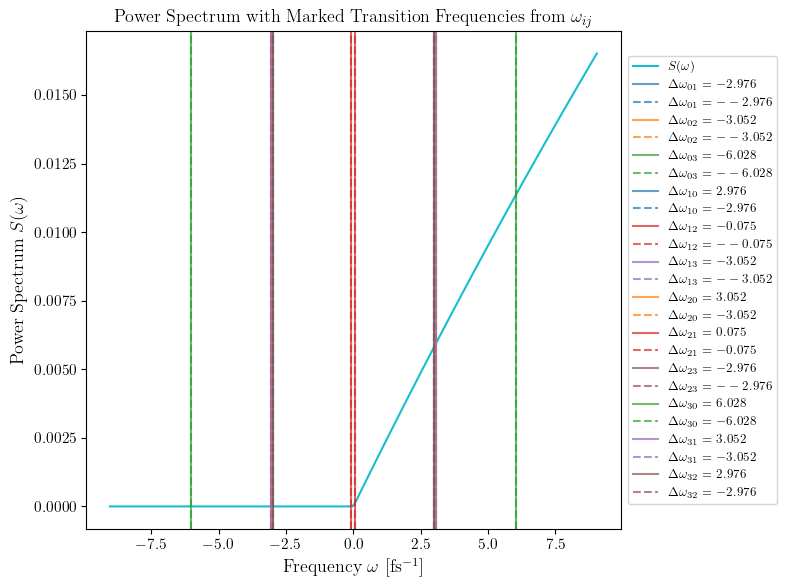

In [ ]:
max = np.max(np.abs(omegaij))
w_extended = np.linspace(-1.5 * max, 1.5 * max, 200)  # Extend to cover up to 1.5 * max |omegaij|

plt.figure()
# Plot the power spectrum
plt.plot(w_extended, S(w_extended), label=r'$S(\omega)$', color=COLORS[-1], linestyle=LINE_STYLES[0])

unique_pairs = [(i, j) for i in range(dim) for j in range(i + 1, dim)]
pair_to_color = {pair: COLORS[k % len(COLORS)] for k, pair in enumerate(unique_pairs)}
for i in range(dim):
    for j in range(dim):
        if i != j:
            omega = omegaij[i, j]
            pair = tuple(sorted((i, j)))
            color = pair_to_color[pair]
            plt.axvline(omega, color=color, linestyle=LINE_STYLES[0], alpha=0.7, label=f'$\Delta \omega_{{{i}{j}}} = {omega:.3f}$')
            plt.axvline(-omega, color=color, linestyle=LINE_STYLES[1], alpha=0.7, label=f'$\Delta \omega_{{{i}{j}}} = -{omega:.3f}$')
plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
plt.ylabel(r'Power Spectrum $S(\omega)$')
plt.title(r'Power Spectrum with Marked Transition Frequencies from $\omega_{ij}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.show()

## Power Spectrum Visualization

This plot shows the bath power spectrum $S(\omega)$ and marks the transition frequencies $\omega_{ij}$ for the system, providing insight into the spectral overlap and dissipative processes.

In [ ]:
args = extract_bath_parameters(sim_oqs.bath)
args["temp"] = args["T"]
args["cutoff"] = args["wc"]

print("bath at 0", args["S(0)"])
P_ohmic_0 = power_spectrum_func_ohmic(0, **args)
args["alpha"] = args["alpha"] * args["wc"]  # Convert back to original alpha definition
P_0 = power_spectrum_func_paper(0, **args)
P_0, P_ohmic_0

bath at 0 2e-09


(1.9999999999999997e-09, 2e-09)

In [ ]:
sb = sim_oqs.sb_coupling
S(0), sb.paper_Gamma_ij(1,0)

(2e-09, np.float64(2e-09))

In [ ]:
from qspectro2d.core.simulation import matrix_ODE_paper
sec_cutoff = 0
times = sim_oqs.times_global
H = sim_oqs.evo_obj # QobjEvo
t_peak = sim_oqs.laser.pulse_peak_times[0]

# TODO build the redfield tensor for both time points to check weather or not it is time dependent
H_peak = H(t_peak)
R_tpeak_qutip = bloch_redfield_tensor(H_peak, sim_oqs.decay_channels, sec_cutoff=sec_cutoff)[0]

R_tpeak_paper = matrix_ODE_paper(t_peak, sim_oqs)

c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\qutip\utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


## Redfield tensor comparison metrics

Quantify the difference between the custom Bloch-Redfield implementation and QuTiP's reference tensor using matrix norms.

In [ ]:
diff = (R_tpeak_qutip - R_tpeak_paper).full()
frob_norm = float(np.linalg.norm(diff))
inf_norm = float(np.max(np.abs(diff)))
print("‖ΔR‖_F =", frob_norm)
print("‖ΔR‖_∞ =", inf_norm)

‖ΔR‖_F = 0.23861411206912567
‖ΔR‖_∞ = 0.08518004886437862


(<Figure size 800x600 with 2 Axes>, <Axes3D: >)

c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


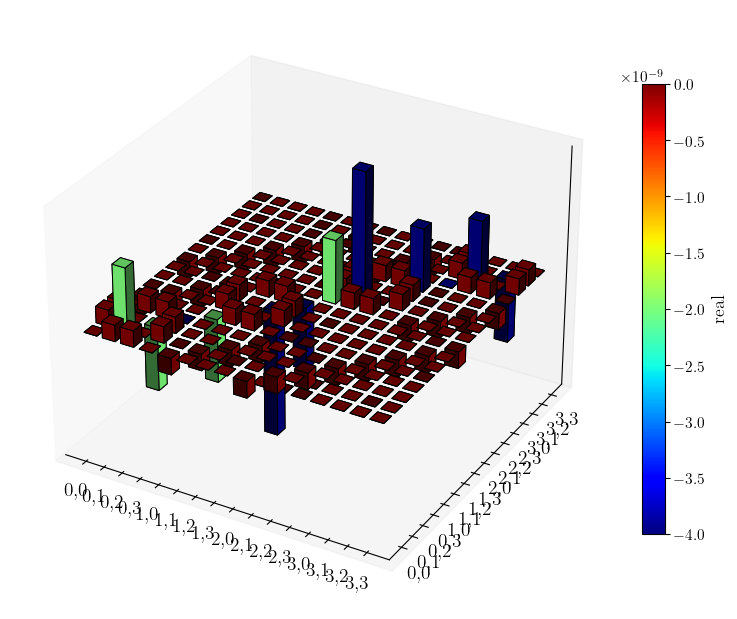

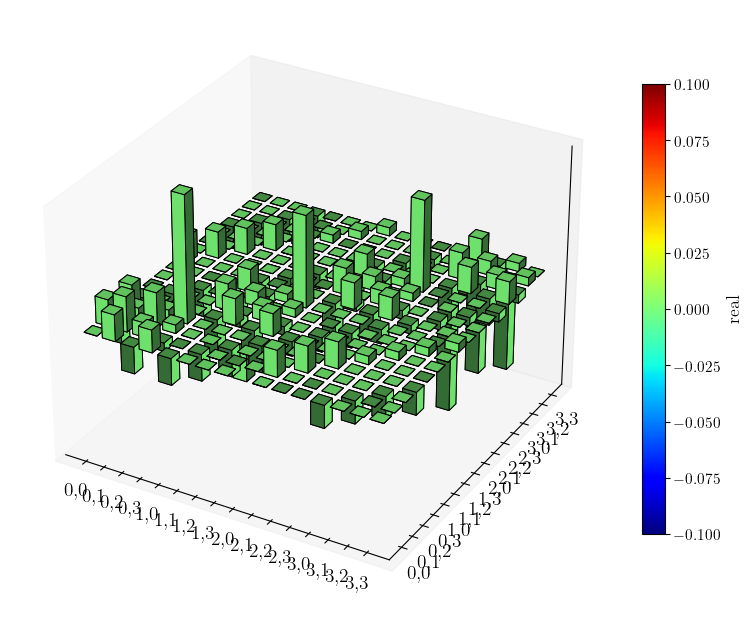

In [ ]:
# xbasis 0<-0, 0<-1, 0<-2, 0<-3, 1<-0, 1<-1, 1<-2, 1<-3, 2<-0, 2<-1, 2<-2, 2<-3, 3<-0, 3<-1, 3<-2, 3<-3
dims = sim_oqs.system.dimension
xbasis = [f"{i},{j}" for i in range(dims) for j in range(dims)]
ybasis = xbasis.copy()
matrix_histogram(R_tpeak_paper, bar_style="img", x_basis=xbasis, y_basis=ybasis)
matrix_histogram(R_tpeak_qutip, bar_style="img", x_basis=xbasis, y_basis=ybasis)